In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.6 MB/s eta 0:00:00


In [ ]:
# imported nexessory libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loaded time series data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dissertation/uk_tourism_dataset.csv');

In [ ]:
df.head()

,Date,All Visits,North America,Europe,Other Countries
0,Jan-18,2734,321,1790,623
1,Feb-18,2573,262,1870,440
2,Mar-18,3240,354,2405,480
3,Apr-18,3404,453,2423,528
4,May-18,3614,560,2417,637


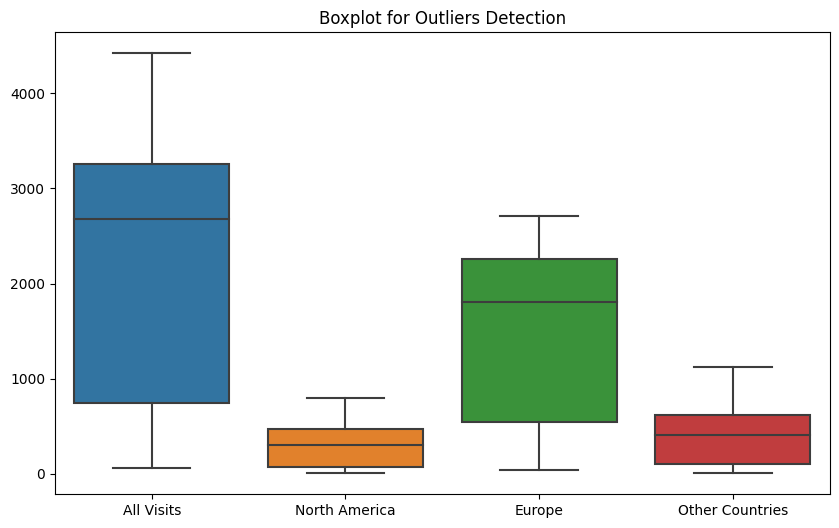

In [ ]:
# Boxplot to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title('Boxplot for Outliers Detection')
plt.show()

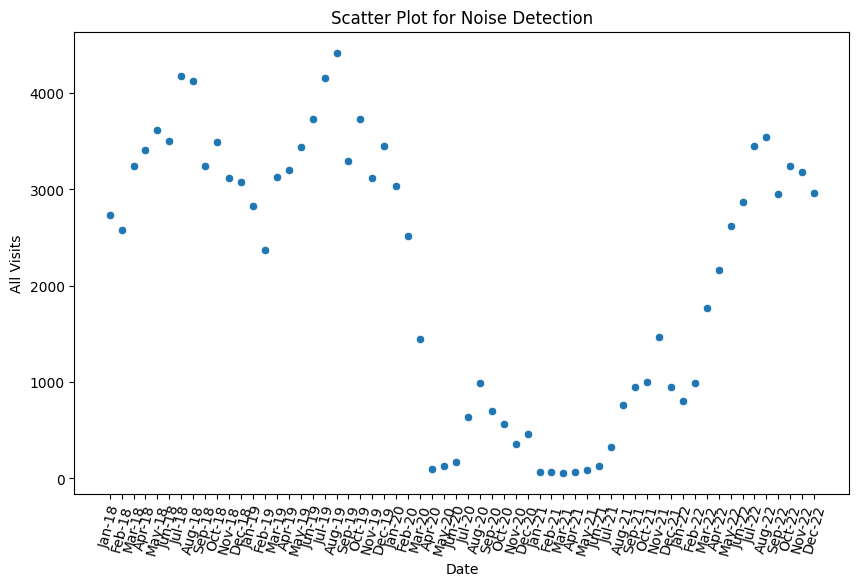

In [ ]:
# Scatter plot for two variables to identify noise
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Date', y='All Visits', data=df)
plt.xticks(rotation=75)
plt.title('Scatter Plot for Noise Detection')
plt.show()

In [ ]:
df.head()

,Date,All Visits,North America,Europe,Other Countries
0,Jan-18,2734,321,1790,623
1,Feb-18,2573,262,1870,440
2,Mar-18,3240,354,2405,480
3,Apr-18,3404,453,2423,528
4,May-18,3614,560,2417,637


<Axes: >

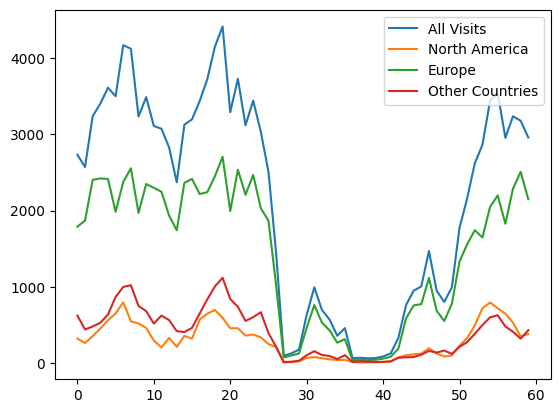

In [ ]:
df.plot()

In [ ]:
# dropping unwanted columns from dataset
df = df.drop(columns=['North America','Europe','Other Countries'])

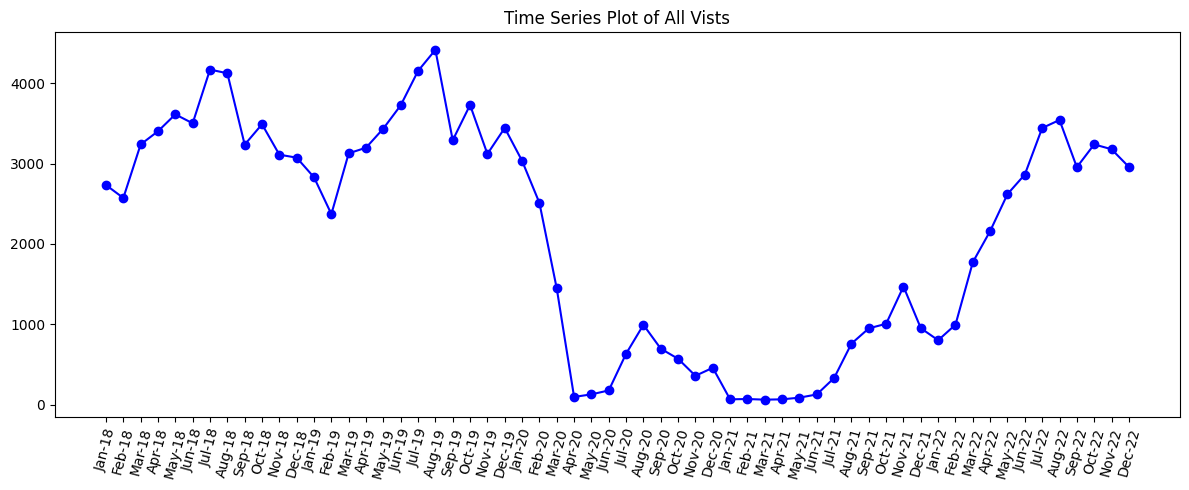

In [ ]:
# Create the plot
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['All Visits'] , marker='o', linestyle='-', color='b')
# Add title and axis labels
plt.title('Time Series Plot of All Vists')
# plt.xticks(rotation=90)
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()
# Display the plot
# plt.show()

Decomposition

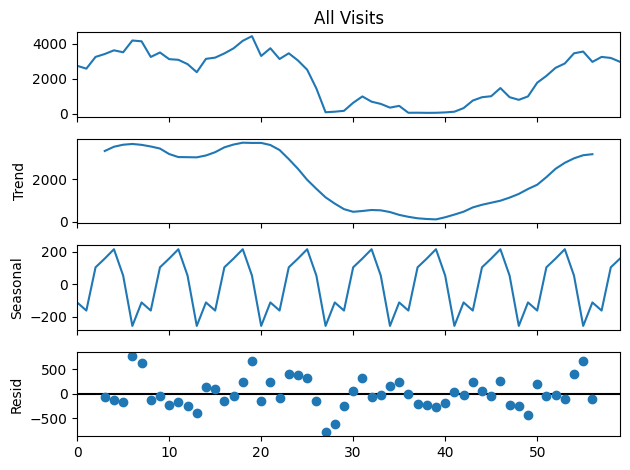

In [ ]:
decompose = seasonal_decompose(df['All Visits'],model='additive', period=7)
decompose.plot()
plt.show()

In [ ]:
from datetime import datetime
dates_series = pd.Series(df['Date'])

#converted date format
def convert_date(input_date):
    date_obj = datetime.strptime(input_date, "%b-%y")
    new_date = datetime(date_obj.year, date_obj.month, 1)
    return new_date.strftime("%Y-%m-%d")

# Applied the conversion function to the Series
formatted_dates_series = dates_series.apply(convert_date)
df['Date'] = formatted_dates_series

In [ ]:
# Convert the date column to a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Set the date column as the index
df.set_index('Date', inplace=True)

## Stationary

In [ ]:
# import the adfuller function from statsmodel
# package to perform ADF test
X = df['All Visits'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -1.739714
p-value: 0.410775
Critical Values:
	1%: -3.551
	5%: -2.914
	10%: -2.595
Failed to Reject Ho - Time Series is Non-Stationary


In [ ]:
df['ln_all_visits'] = np.log(df['All Visits'])


In [ ]:
# import the adfuller function from statsmodel
# package to perform ADF test
X = df['ln_all_visits'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -1.891741
p-value: 0.335956
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594
Failed to Reject Ho - Time Series is Non-Stationary


In [ ]:
diff = df['ln_all_visits'].diff()
df['ln_all_visits_diff'] = diff

In [ ]:
df['ln_all_visits_diff'].fillna(0, inplace = True)

In [ ]:
# import the adfuller function from statsmodel
# package to perform ADF test
X = df['ln_all_visits_diff'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -6.434572
p-value: 0.000000
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594
Reject Ho - Time Series is Stationary


<Axes: xlabel='Date'>

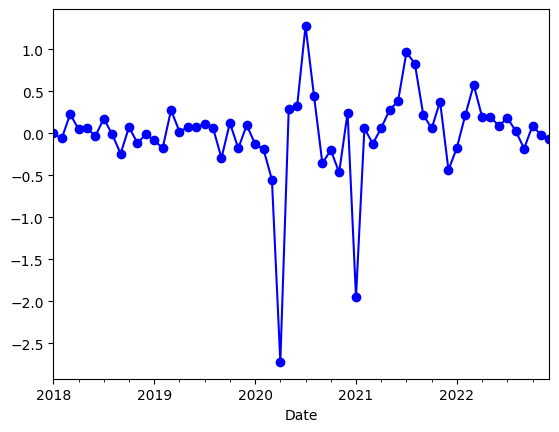

In [ ]:
df['ln_all_visits_diff'].plot(marker='o', linestyle='-', color='b')

## Auto correlation and partial correlation

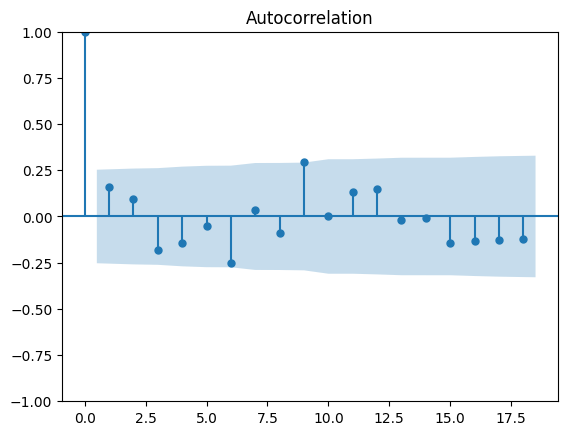

In [ ]:
plot_acf(df['ln_all_visits_diff'])
plt.show()

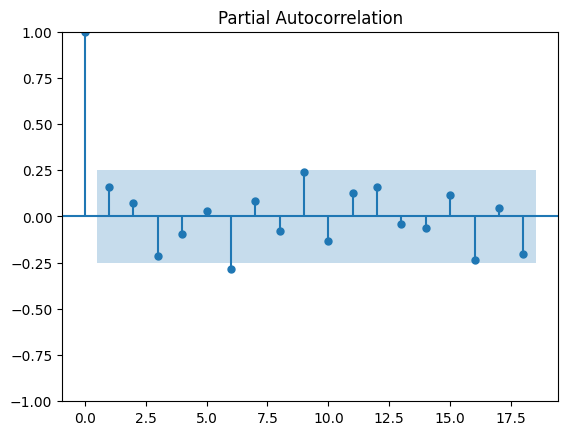

In [ ]:
plot_pacf(df['ln_all_visits_diff'])
plt.show()

##Decomposition

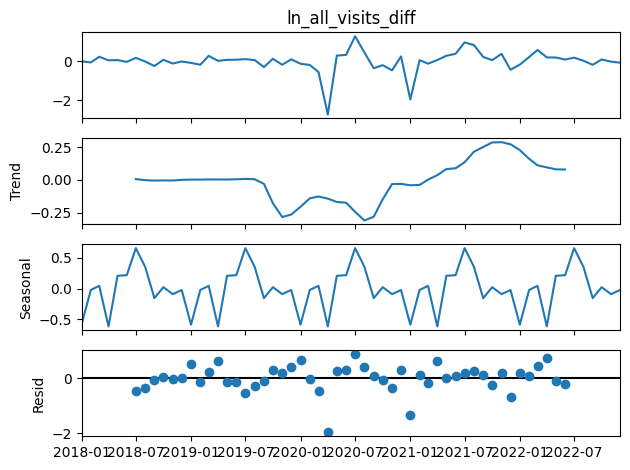

In [ ]:
decompose = seasonal_decompose(df['ln_all_visits_diff'],model='additive', period=12)
decompose.plot()
plt.show()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

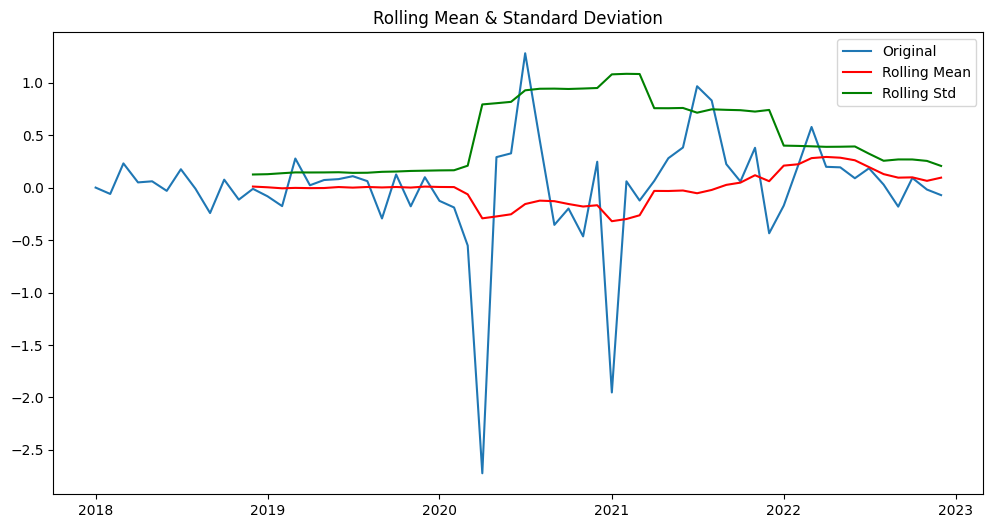

In [ ]:
# Calculate rolling statistics
rolling_mean = df['ln_all_visits_diff'].rolling(window=12).mean()
rolling_std = df['ln_all_visits_diff'].rolling(window=12).std()
# Plot rolling statistics
plt.figure(figsize=(12, 6))
plt.plot(df['ln_all_visits_diff'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='green')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

In [ ]:
model = auto_arima(df['ln_all_visits_diff'], seasonal=True, m=12, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=104.194, Time=2.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=99.818, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=101.330, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=101.564, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=97.818, Time=0.09 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=100.666, Time=0.18 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=100.614, Time=0.10 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=102.589, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=100.320, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=100.585, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=102.237, Time=0.21 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12]          
Total fit time: 4.308 seconds


In [ ]:
p, d, q = model.order
seasonal_p, seasonal_d, seasonal_q, m = model.seasonal_order

best_arima_model = ARIMA(df['ln_all_visits_diff'], order=(p, d, q), seasonal_order=(seasonal_p, seasonal_d, seasonal_q, m))
results = best_arima_model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:     ln_all_visits_diff   No. Observations:                   60
Model:                          ARIMA   Log Likelihood                 -47.909
Date:                Wed, 04 Oct 2023   AIC                             99.818
Time:                        15:05:08   BIC                            104.007
Sample:                    01-01-2018   HQIC                           101.457
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.096      0.014      0.989      -0.188       0.190
sigma2         0.2891      0.028     10.348      0.000       0.234       0.344
Ljung-Box (L1) (Q):                   1.58   Jarque-

In [ ]:
forecast_periods = 12  # Change this to the number of periods you want to forecast
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

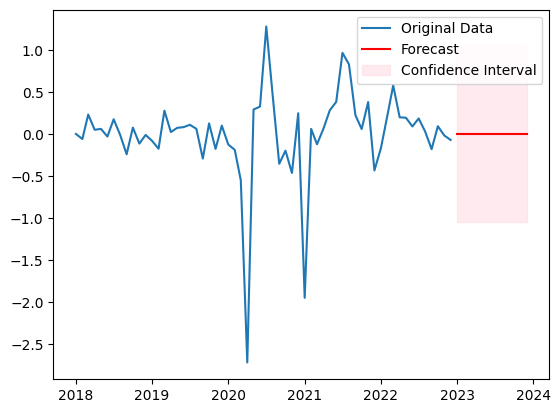

In [ ]:
# Plot the original data
plt.plot(df['ln_all_visits_diff'], label='Original Data')

# Plot the forecasted mean
plt.plot(forecast_mean.index, forecast_mean.values, color='red', label='Forecast')

# Fill the confidence interval
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

plt.legend()
plt.show()


In [ ]:
# Replace 'actual_values' with the actual values of your time series data
actual_values = df['ln_all_visits_diff'].tail(forecast_periods)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_values, forecast_mean)
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, forecast_mean)
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Calculate the Root Mean Squared Error (RMSE)
rmse = sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


Mean Absolute Error (MAE): 0.17
Mean Squared Error (MSE): 0.05
Root Mean Squared Error (RMSE): 0.22


# Elman's Model of ANN

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [ ]:
df.head()

,All Visits,ln_all_visits,ln_all_visits_diff
Date,,,
2018-01-01,2734,7.913521,0.000000
2018-02-01,2573,7.852828,-0.060693
2018-03-01,3240,8.083329,0.230501
2018-04-01,3404,8.132706,0.049378
2018-05-01,3614,8.192570,0.059864


In [ ]:
# Sort the data by date
df.sort_values(by='Date', inplace=True)

In [ ]:
# Normalize the 'All Visits' column using Min-Max scaling
scaler = MinMaxScaler()
df['All Visits'] = scaler.fit_transform(df['All Visits'].values.reshape(-1, 1))

In [ ]:
# Define a function to prepare the data for training
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
# Set the number of timesteps to look back
look_back = 12

In [ ]:
# Prepare the data
data = df['All Visits'].values.reshape(-1, 1)
X, Y = create_dataset(data, look_back)

In [ ]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [ ]:
# Build the Elman's model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
2/2 [==============================] - 4s 23ms/step - loss: 0.1828
Epoch 2/100
2/2 [==============================] - 0s 17ms/step - loss: 0.1322
Epoch 3/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0964
Epoch 4/100
2/2 [==============================] - 0s 12ms/step - loss: 0.0697
Epoch 5/100
2/2 [==============================] - 0s 15ms/step - loss: 0.0488
Epoch 6/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0377
Epoch 7/100
2/2 [==============================] - 0s 29ms/step - loss: 0.0311
Epoch 8/100
2/2 [==============================] - 0s 20ms/step - loss: 0.0328
Epoch 9/100
2/2 [==============================] - 0s 21ms/step - loss: 0.0374
Epoch 10/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0394
Epoch 11/100
2/2 [==============================] - 0s 20ms/step - loss: 0.0367
Epoch 12/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0319
Epoch 13/100
2/2 [==============================]

In [ ]:
# Make predictions on the test set
test_predictions = model.predict(X_test)

1/1 [==============================] - 0s 408ms/step


In [ ]:
# Inverse transform the predictions to the original scale
test_predictions = scaler.inverse_transform(test_predictions)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

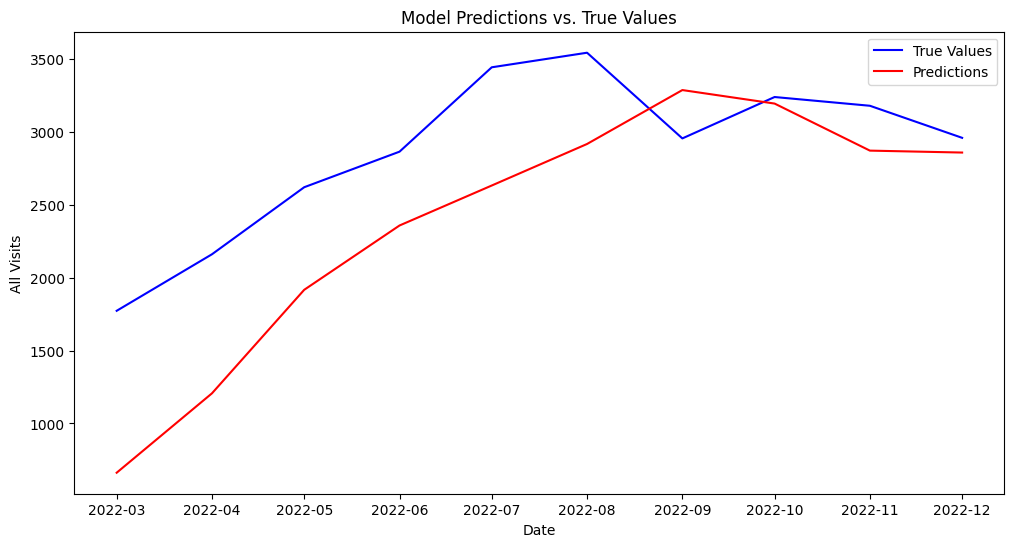

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(test_predictions):], Y_test, label='True Values', color='blue')
plt.plot(df.index[-len(test_predictions):], test_predictions, label='Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('All Visits')
plt.title('Model Predictions vs. True Values')
plt.legend()
plt.show()

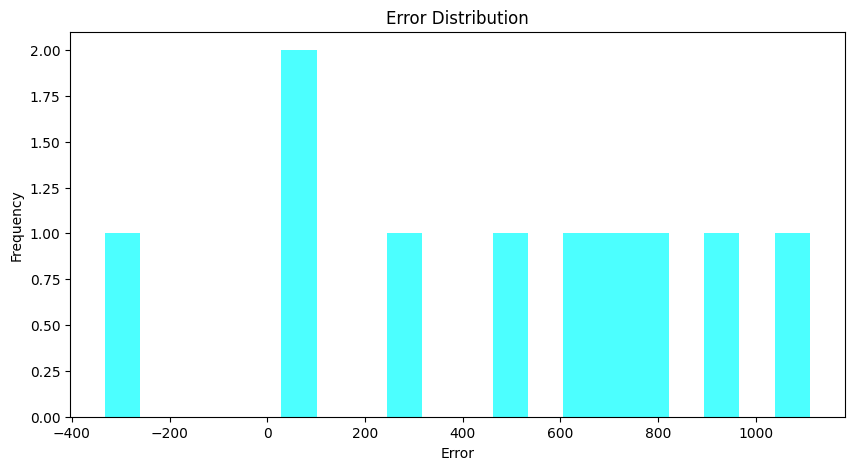

In [ ]:
residuals = Y_test - test_predictions
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20, color='cyan', alpha=0.7)
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Calculate RMSE (Root Mean Squared Error) as a performance metric
rmse = np.sqrt(mean_squared_error(Y_test, test_predictions))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 645.3787800515561


In [ ]:
# Calculate MAE and MSE
mae = mean_absolute_error(Y_test, test_predictions)
mse = mean_squared_error(Y_test, test_predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

Mean Absolute Error (MAE): 549.9239990234375
Mean Squared Error (MSE): 416513.7697408348


# Exponencial Smoothing

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
# Split your data into training and testing sets
train_size = int(len(df) * 0.8)  # 80% for training
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [ ]:
# Fit an Exponential Smoothing model
model = ExponentialSmoothing(train_data['All Visits'], seasonal='add', seasonal_periods=12)

# Fit the model without the box-cox transformation
model_fit = model.fit(optimized=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# Use the fitted model to make predictions on the test set
predictions = model_fit.forecast(len(test_data))

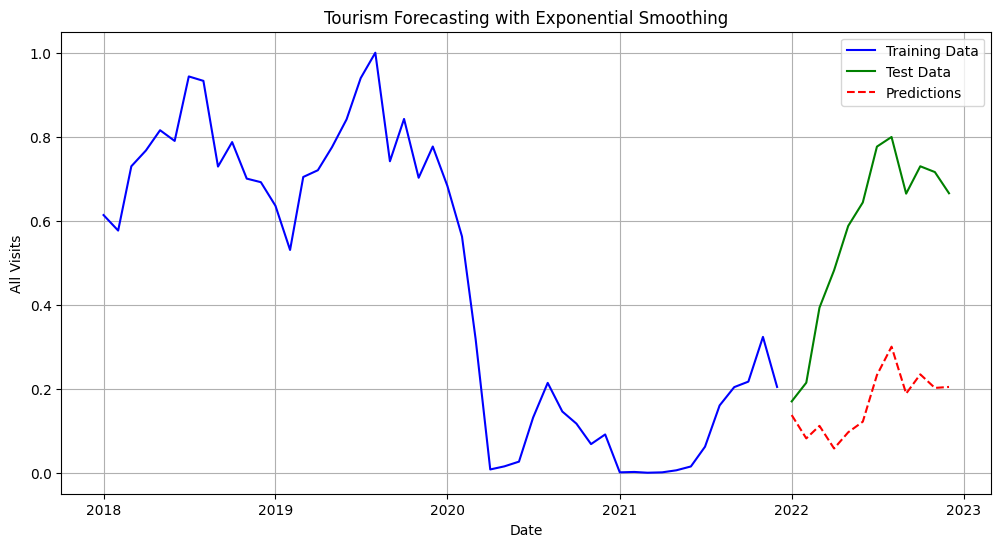

In [ ]:
# Plot the training data, test data, and predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['All Visits'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['All Visits'], label='Test Data', color='green')
plt.plot(test_data.index, predictions, label='Predictions', color='red', linestyle='--')
plt.legend(loc='best')
plt.title('Tourism Forecasting with Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('All Visits')
plt.grid(True)
plt.show()

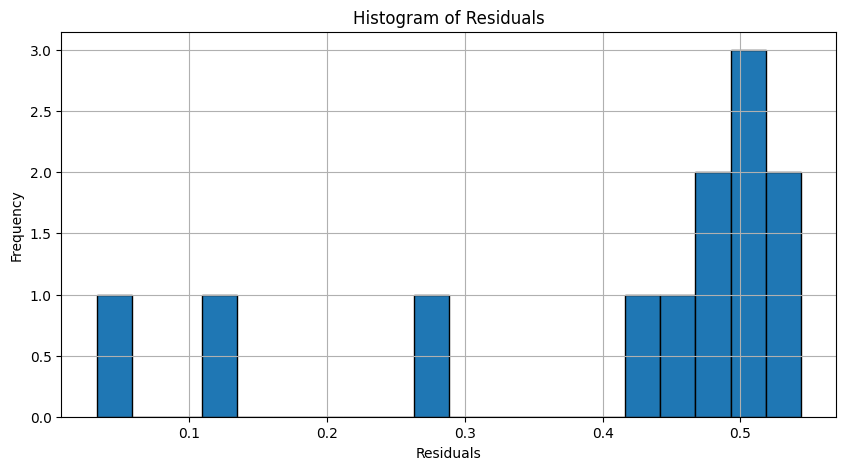

In [ ]:
# Plot a histogram of the residuals (prediction errors)
residuals = test_data['All Visits'] - predictions
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

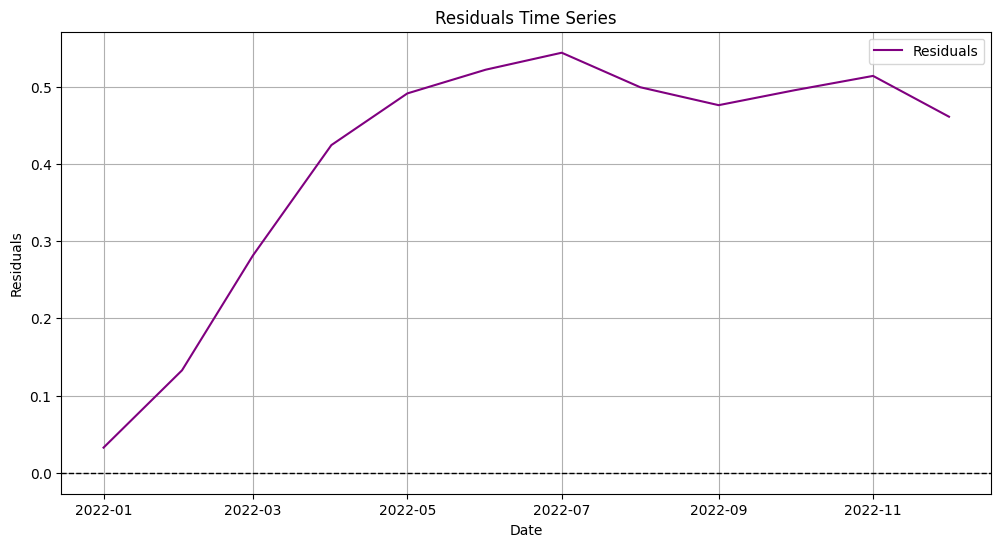

In [ ]:
# Plot a time series of the residuals
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, residuals, label='Residuals', color='purple')
plt.axhline(y=0, color='black', linestyle='--', lw=1)
plt.legend(loc='best')
plt.title('Residuals Time Series')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In [ ]:
# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data['All Visits'], predictions)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(test_data['All Visits'], predictions)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 0.41
Mean Squared Error (MSE): 0.19
Root Mean Squared Error (RMSE): 0.44


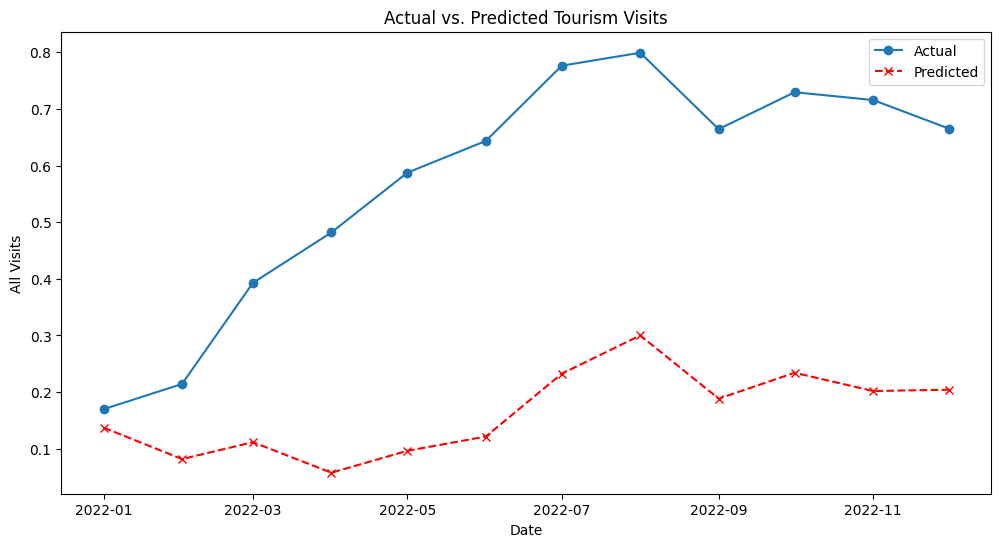

In [ ]:
# Plot the predicted vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['All Visits'], label='Actual', marker='o')
plt.plot(test_data.index, predictions, label='Predicted', color='red', linestyle='--', marker='x')
plt.legend(loc='best')
plt.title('Actual vs. Predicted Tourism Visits')
plt.xlabel('Date')
plt.ylabel('All Visits')
plt.show()